In [2]:
#import k3d
import sys
sys.path.insert(0, "/eos/user/j/jrimmer/Geometry")
sys.path.insert(0, "../")
sys.path.insert(0, "../LicketyFit")
#from model_muon_cherenkov_collapse import *
from Geometry.Device import Device
from LicketyFit.Emitter import *
from LicketyFit.Emitter import Emitter
from LicketyFit.Event import SimulatedEvent
from LicketyFit.PMT import PMT
from LicketyFit.Fitter import Fitter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('dark_background')

In [3]:
geo_path = '/eos/user/j/jrimmer/Geometry/examples/wcte_bldg157.geo'

# Build the WCTE detector using the geometry file that includes survey data
hall = Device.open_file(geo_path)
wcte = hall.wcds[0]
n_mpmt = len(wcte.mpmts)

# Create an empty simulated event - and turn on all PMTs
simulated_event = SimulatedEvent(run_number=1, serial_number=1, n_mpmt=n_mpmt)
for i_mpmt in range(n_mpmt):
    if wcte.mpmts[i_mpmt] is None:
        continue
    simulated_event.mpmt_status[i_mpmt] = True
    for i_pmt in range(simulated_event.npmt_per_mpmt):
        if wcte.mpmts[i_mpmt].pmts[i_pmt] is None:
            continue
        simulated_event.pmt_status[i_mpmt][i_pmt] = True

# Create an emitter
# consider 2 tracks
#  1: starting 400 mm upstream of WCTE axis centre and stopping at the axis centre
#  2: starting at the axis centre and going 800 mm downstream

choice = 1

if choice == 1:
    starting_time = 0.
    start_coord = (0, 0, -1000)
    cxy = 0.0
    direction = (cxy, cxy, np.sqrt(1.-2*cxy**2))
    #beta = 0.9999
    beta = 0.96
    length = 1165
    intensity = 5.  # expected PE at 1 meter from track for PMT at normal incidence
    
    
    
elif choice == 2:
    starting_time = 10.
    start_coord = (0.2, 0., 0.)
    cxy = 0.01
    direction = (cxy, cxy, np.sqrt(1.-2*cxy**2))
    beta = 0.9999
    length = 2000.
    intensity = 5.  # expected PE at 1 meter from track for PMT at normal incidence
else:
    print("Invalid choice")

if choice  in [1,2]:
    print(f'Emitter choice {choice}: start_coord={start_coord}, direction={direction}, length={length} mm')
    emitter = Emitter(starting_time, start_coord, direction, beta, length, intensity)

# Simulate the emission and record hits in the simulated event
    costs, mean_pes = emitter.emit(simulated_event, wcte, place_info='design')

Emitter choice 1: start_coord=(0, 0, -1000), direction=(0.0, 0.0, np.float64(1.0)), length=1165 mm
COSINE 0.7787590119109392
INIT ENERGY 300.0
BETA VALUE IS 0.9654844281071472
PMT RADIUS 37.5


In [3]:
simulated_event.__repr__()

'SimulatedEvent(run_number=1, serial_number=1, n_mpmt=106, npmt_per_mpmt=19, n_emitters=1)'

In [4]:
extra = '_x0_y0_zn1000_l1165mm'
if choice != 1:
    extra = str(choice)
simulated_event.save('./simple_sim_data/wcte_simulated_event'+extra+'.npz')

In [5]:
simulated_event = SimulatedEvent.load('wcte_simulated_event.npz')

In [7]:
data = np.load('wcte_simulated_event.npz',allow_pickle=True)

In [3]:
E_vs_dist = np.load('E_vs_dist.npy', allow_pickle=True) # need to convert this from cm to mm later
overall_distances = np.load('overall_distances.npy')*10 # convert to mm

energy = np.array([a[:, 1] for a in E_vs_dist], dtype=object)
distances = np.array([a[:, 0] for a in E_vs_dist], dtype=object)*10 #change to mm

In [5]:
overall_distances[145]

np.float64(663.0000000000051)

In [4]:
energy[145]

array([200.        , 199.79862006, 199.59722377, 199.39581107,
       199.19438189, 198.99293616, 198.79147384, 198.58999484,
       198.38849912, 198.1869866 , 197.98545722, 197.78391091,
       197.58234762, 197.38076728, 197.17916982, 196.97755517,
       196.77592328, 196.57427406, 196.37260747, 196.17092343,
       195.96922188, 195.76750274, 195.56576596, 195.36401146,
       195.16223918, 194.96044904, 194.75864099, 194.55681495,
       194.35497085, 194.15310863, 193.95122821, 193.74932953,
       193.54741251, 193.34547709, 193.1435232 , 192.94155076,
       192.73955971, 192.53754997, 192.33552147, 192.13347414,
       191.93140791, 191.72932271, 191.52721846, 191.32509509,
       191.12295253, 190.9207907 , 190.71860954, 190.51640896,
       190.3141889 , 190.11194927, 189.90969001, 189.70741104,
       189.50511229, 189.30279367, 189.10045511, 188.89809654,
       188.69571788, 188.49331905, 188.29089997, 188.08846058,
       187.88600078, 187.68352051, 187.48101968, 187.27

In [13]:
s_max_mm = 1145

main_idx = np.searchsorted(overall_distances, s_max_mm)

# keep indices in range
main_idx = np.clip(main_idx, 1, len(overall_distances) - 1)

# choose nearest of left/right neighbors
left = overall_distances[main_idx - 1]
right = overall_distances[main_idx]

main_idx -= (s_max_mm - left) <= (right - s_max_mm)


In [14]:
main_idx

np.int64(241)

In [15]:
energy[241]

array([296.        , 295.80199767, 295.603994  , ...,  55.24263575,
        54.96813508,  54.69305665])

In [16]:
init_E_vs_dist_travelled = np.load('../examples/init_E_vs_dist_travelled.npy')
dist_travelled = init_E_vs_dist_travelled[:,0]
init_energy = init_E_vs_dist_travelled[:,1]

In [17]:
interp_E_init = np.interp(1145, dist_travelled*10, init_energy) # Convert distance to mm

In [18]:
interp_E_init

np.float64(296.0)

In [8]:
p45_location = wcte.mpmts[45].pmts[0].get_placement('design')
print(f'mPMT 45 PMT 0 location: {p45_location["location"]}, direction_z: {p45_location["direction_z"]}')
p37_location = wcte.mpmts[37].pmts[0].get_placement('design')
print(f'mPMT 37 PMT 0 location: {p37_location["location"]}, direction_z: {p37_location["direction_z"]}')
p0_location = wcte.mpmts[0].pmts[0].get_placement('design')
print(f'mPMT 0 PMT 0 location: {p0_location["location"]}, direction_z: {p0_location["direction_z"]}')
p85_location = wcte.mpmts[85].pmts[0].get_placement('design')
print(f'mPMT 85 PMT 0 location: {p85_location["location"]}, direction_z: {p85_location["direction_z"]}')

mPMT 45 PMT 0 location: [np.float64(1.4909174536583212e-13), np.float64(2.70335531737942e-13), np.float64(-1464.2830000000001)], direction_z: [np.float64(-2.4492935982947054e-16), np.float64(-4.440892098500629e-16), np.float64(1.0)]
mPMT 37 PMT 0 location: [np.float64(3.0224283002956665e-14), np.float64(-2.7033553173794193e-13), np.float64(1464.2830000000001)], direction_z: [np.float64(1.2246467991473527e-16), np.float64(4.440892098500626e-16), np.float64(-1.0)]
mPMT 0 PMT 0 location: [np.float64(-5.480060849549773e-14), np.float64(-858.675), np.float64(5.480060849549773e-14)], direction_z: [np.float64(-2.220446049250313e-16), np.float64(1.0), np.float64(2.220446049250313e-16)]
mPMT 85 PMT 0 location: [np.float64(2.4576325492541052e-14), np.float64(1708.2), np.float64(-5.480060849549772e-14)], direction_z: [np.float64(9.957992501029598e-17), np.float64(-1.0), np.float64(-2.2204460492503123e-16)]


In [9]:
count_pmt = 0
count_hit_pmt = 0
mpmts_hit = []
hit_times = []
pe_sum = 0
max_pe = -1
for i_mpmt in range(n_mpmt):
    if simulated_event.mpmt_status[i_mpmt]:
        for i_pmt in range(simulated_event.npmt_per_mpmt):
            if simulated_event.pmt_status[i_mpmt][i_pmt]:
                count_pmt += 1
                if len(simulated_event.expected_hit_pe[i_mpmt][i_pmt]) > 0:
                    count_hit_pmt += 1
                    if i_mpmt not in mpmts_hit:
                        mpmts_hit.append(i_mpmt)
                for hit_pe in simulated_event.expected_hit_pe[i_mpmt][i_pmt]:
                    pe_sum += hit_pe
                    max_pe = max(max_pe, hit_pe)
                for hit_time in simulated_event.expected_hit_times[i_mpmt][i_pmt]:
                    hit_times.append(hit_time)


print(f'Number of PMTs: {count_pmt}, Number of hit PMTs: {count_hit_pmt}, Total PE: {pe_sum}')
print(f'{len(mpmts_hit)} mPMTs hit: {mpmts_hit}')
print(f'Mean hit time: {np.mean(hit_times):.2f} ns, RMS hit time: {np.std(hit_times):.2f} ns')
print(f'Max PE on a single PMT: {max_pe:.2f}')

Number of PMTs: 2014, Number of hit PMTs: 156, Total PE: 257.7655937940245
16 mPMTs hit: [1, 2, 8, 10, 20, 23, 35, 39, 51, 55, 67, 70, 71, 83, 84, 94]
Mean hit time: 18.71 ns, RMS hit time: 1.14 ns
Max PE on a single PMT: 3.00


In [3]:
# visualize intensities in 3D
# Show numbering and orientation of all mPMTs and the observed intensity

plot = k3d.plot()

max_nu = 5 # 0.4 # adjust this to scale the color map
cmap=mpl.colormaps['plasma']

color_mpmt = 0xabb2b9

n_point_mpmt = 8
indices_mpmt = []
for i in range(n_point_mpmt):
    indices_mpmt.append([i,(i+1)%n_point_mpmt])

fd_mpmts =[12,14,16,18] # do not draw these ones

# pmt faces:
#color_pmt = 0xdc7633
color_pmt = 0x7d7f7c
n_point_pmt = 20
indices_pmt = []
for i in range(n_point_pmt):
    indices_pmt.append([i,(i+1)%n_point_pmt])

# draw the extent of the mpmt baseplates
for i_mpmt,mpmt in enumerate(wcte.mpmts):

    if not simulated_event.mpmt_status[i_mpmt] or i_mpmt in fd_mpmts:
        continue # skip mPMTs that do not exist

    p = mpmt.get_placement('design')
    location, direction_x, direction_z = p['location'], p['direction_x'], p['direction_z']
    direction_y = np.cross(direction_z,direction_x)

    if location[2] < -800:
        continue # skip upstream mPMTs to reduce clutter

    baseplate_points = np.array(mpmt.get_xy_points('design'),dtype=np.float32)
    plt_baseplate = k3d.lines(baseplate_points, indices_mpmt, indices_type='segment', color=color_mpmt)
    plot += plt_baseplate

    # k3d complains about the following not being float32!
    plt_text = k3d.text(mpmt.name, position=location, reference_point='cc', size=1., label_box=False, color=color_mpmt)
    plot += plt_text

    for i_pmt, pmt in enumerate(mpmt.pmts):

        if not simulated_event.pmt_status[i_mpmt][i_pmt]:
            continue # skip PMTs that do not exist

        if len(simulated_event.expected_hit_pe[i_mpmt][i_pmt]) == 0:
            continue # skip PMTs that were not hit

        p = pmt.get_placement('design')
        location, direction_x, direction_z = p['location'], p['direction_x'], p['direction_z']
        direction_y = np.cross(direction_z,direction_x)

        circle_points = pmt.get_circle_points(n_point_pmt,'design')
        circle_vertices = [location] + circle_points
        the_indices = []
        the_indices_rev = []
        for i in range(1,len(circle_points)-1):
            the_indices += [0,i,i+1]
            the_indices_rev += [0,i+1,i]
        the_indices += [0,len(circle_points)-1,1]
        the_indices_rev += [0,1,len(circle_points)-1]

        exp_val = 0
        for hit_pe in simulated_event.expected_hit_pe[i_mpmt][i_pmt]:
            exp_val += hit_pe
        value = max(0.,min(1.,abs(exp_val/max_nu)))
        rgb = cmap(abs(value))[:3]  # will return rgba, we take only first 3 so we get rgb
        color_str = mpl.colors.rgb2hex(rgb)
        color_int = int(color_str[1:],16)

        mesh = k3d.mesh(circle_vertices, [the_indices], color=color_int)
        plot += mesh
        # need to do in reverse to see from both sides
        mesh2 = k3d.mesh(circle_vertices, [the_indices_rev], color=color_int)
        plot += mesh2

        # k3d complains about the following not being float32!
        plt_text = k3d.text(str(i_pmt), position=location, reference_point='cc', size=0.5, label_box=False, color=color_pmt)
        plot += plt_text

# emitters
emitter_origins = []
emitter_vecs = []
color_emitter = 0x00ff00

for em in simulated_event.emitters:
    emitter_origins.append(em.start_coord)
    unit_vec = np.array(em.direction, dtype=np.float32)
    emitter_vecs.append(unit_vec*em.length)

plt_emitter_vecs = k3d.vectors(origins=emitter_origins, vectors=emitter_vecs, color=color_emitter, head_size=50.)
plot += plt_emitter_vecs

# spatial extent of the emitters
color_intersection = 0xff0000
color_intersection_offset = 0x990000
n_point_intersection = 100
indices_intersection = []
for i in range(n_point_intersection):
    indices_intersection.append([i,i+1])

# dimensions of cylindrical can surface
r = 1464.
ht = 1708.
hb = -859.

# show the endcap edges
color_endcap = 0xffffff
indices_endcap = []
for i in range(n_point_intersection):
    indices_endcap.append([i,(i+1)%n_point_intersection])

top_endcap_points = []
bottom_endcap_points = []
phis = np.linspace(0,2*np.pi,n_point_intersection)
top_endcap_points = np.array([[r*np.sin(phi),ht,r*np.cos(phi)] for phi in phis],dtype=np.float32)
bottom_endcap_points = np.array([[r*np.sin(phi),hb,r*np.cos(phi)] for phi in phis],dtype=np.float32)
plt_endcap = k3d.lines(top_endcap_points, indices_endcap, indices_type='segment', color=color_endcap)
plot += plt_endcap
plt_endcap = k3d.lines(bottom_endcap_points, indices_endcap, indices_type='segment', color=color_endcap)
plot += plt_endcap

em = simulated_event.emitters[0]

for i_dflen, dflen in enumerate([-0.02,0.,0.02]):
    color = color_intersection_offset
    if i_dflen == 1:
        color = color_intersection

    points_start = em.get_cone_can_intersection_points(r, ht, hb, n_point_intersection, 0.+dflen)
    points_end = em.get_cone_can_intersection_points(r, ht, hb, n_point_intersection, 1.+dflen)

    intersection_points = np.array(points_start,dtype=np.float32)
    plt_intersection = k3d.lines(intersection_points, indices_intersection, indices_type='segment', color=color)
    plot += plt_intersection

    intersection_points = np.array(points_end,dtype=np.float32)
    plt_intersection = k3d.lines(intersection_points, indices_intersection, indices_type='segment', color=color)
    plot += plt_intersection

plot.background_color = 0x000000
plot.display()

Output()

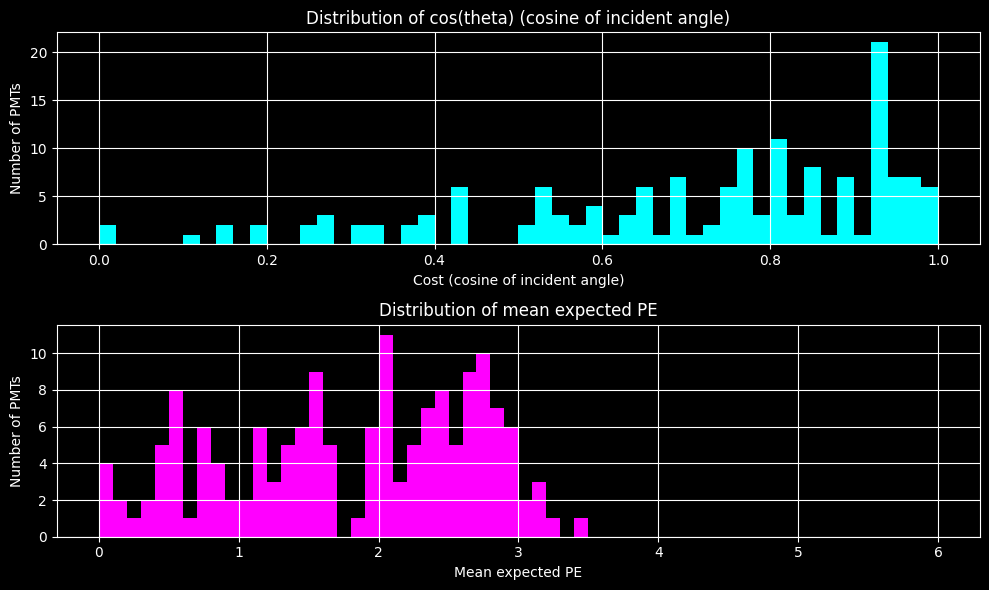

In [4]:
# show 1D distribution of cost (the incident angle) and mean PE
costs = np.array(costs)
mean_pes = np.array(mean_pes)
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.hist(costs, bins=50, range=(0,1.), color='cyan', lw=2)
plt.xlabel('Cost (cosine of incident angle)')
plt.ylabel('Number of PMTs')
plt.title('Distribution of cos(theta) (cosine of incident angle)')
plt.grid()
plt.subplot(2,1,2)
plt.hist(mean_pes, bins=60, range=(0.,6.), color='magenta', lw=2)
plt.xlabel('Mean expected PE')
plt.ylabel('Number of PMTs')
plt.title('Distribution of mean expected PE')
plt.grid()
plt.tight_layout()
#plt.savefig('wcte_cost_pe.png')
plt.show()

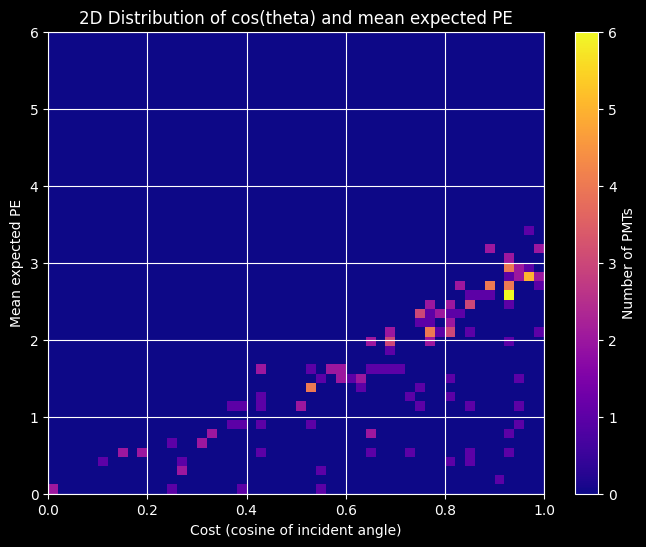

In [5]:
# Show 2D distribution of cost (the incident angle) and mean PE
plt.figure(figsize=(8,6))
plt.hist2d(costs, mean_pes, bins=(50,50), range=((0,1.),(0.,6.)), cmap='plasma')
plt.colorbar(label='Number of PMTs')
plt.xlabel('Cost (cosine of incident angle)')
plt.ylabel('Mean expected PE')
plt.title('2D Distribution of cos(theta) and mean expected PE')
plt.grid()
#plt.savefig('wcte_cost_vs_pe.png')
plt.show()

In [6]:
# Try applying the electronics response
single_pe_amp_mean = 60.
single_pe_amp_std = 20.
single_pe_time_std = 1.
separation_time = 40.
amp_threshold = 20.
noise_rate = 0.
pmt = PMT(single_pe_amp_mean, single_pe_amp_std, single_pe_time_std, separation_time, amp_threshold, noise_rate)

pmt.add_noise(simulated_event)
pmt.apply_response(simulated_event)


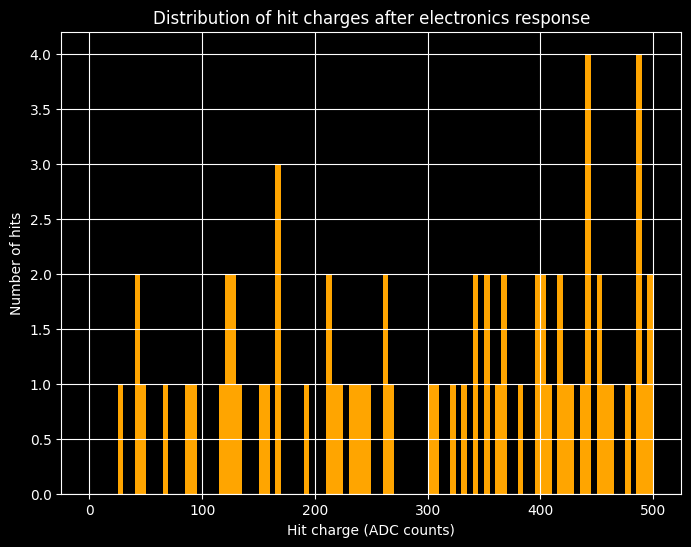

In [39]:
# Show a distribution of hit charges

hit_charges = []
for i_mpmt in range(n_mpmt):
    if simulated_event.mpmt_status[i_mpmt]:
        for i_pmt in range(simulated_event.npmt_per_mpmt):
            if simulated_event.pmt_status[i_mpmt][i_pmt]:
                for charge in simulated_event.hit_charges[i_mpmt][i_pmt]:
                    hit_charges.append(charge)
plt.figure(figsize=(8,6))
plt.hist(hit_charges, bins=100, range=(0.,500.), color='orange', lw=2)
plt.xlabel('Hit charge (ADC counts)')
plt.ylabel('Number of hits')
plt.title('Distribution of hit charges after electronics response')
plt.grid()
#plt.savefig('wcte_hit_charges.png')
plt.show()

In [7]:
# Try out methods for fast likelihood calculation

p_locations, direction_zs = emitter.get_pmt_placements(simulated_event, wcte,'design')

In [8]:
ss = emitter.get_emission_points(p_locations)

In [9]:
exp_pes, exp_ts = emitter.get_expected_pes_ts(wcte, ss, p_locations, direction_zs)

In [12]:
# check that the expected PE and times calculated here matches that in the simulated event
index = 0
i_print = 10
n_match = 0
obs_pes = []
obs_ts = []
obs_qs = []
for i_mpmt in range(n_mpmt):
    if simulated_event.mpmt_status[i_mpmt]:
        for i_pmt in range(simulated_event.npmt_per_mpmt):
            if simulated_event.pmt_status[i_mpmt][i_pmt]:
                obs_pe = 0
                obs_t = None
                obs_q = None
                if len(simulated_event.expected_hit_pe[i_mpmt][i_pmt]) > 0:
                    obs_pe = simulated_event.true_hit_pe[i_mpmt][i_pmt][0]
                    if obs_pe > 0 and len(simulated_event.hit_times[i_mpmt][i_pmt]) > 0:
                        obs_t = simulated_event.hit_times[i_mpmt][i_pmt][0]
                    if obs_pe > 0 and len(simulated_event.hit_charges[i_mpmt][i_pmt]) > 0:
                        obs_q = simulated_event.hit_charges[i_mpmt][i_pmt][0]

                    if simulated_event.expected_hit_pe[i_mpmt][i_pmt][0] != exp_pes[index] and i_print > 0:
                        print(f'Mismatch at index {index}, mPMT {i_mpmt} pmt {i_pmt}, expected {simulated_event.expected_hit_pe[i_mpmt][i_pmt][0]:.2f} vs calculated {exp_pes[index]:.2f}')
                        i_print -= 1
                    else:
                        n_match += 1
                    if simulated_event.expected_hit_times[i_mpmt][i_pmt][0] != exp_ts[index] and i_print > 0:
                        print(f'Mismatch at index {index}, mPMT {i_mpmt} pmt {i_pmt}, expected {simulated_event.expected_hit_times[i_mpmt][i_pmt][0]:.2f} vs calculated {exp_ts[index]:.2f}')
                        i_print -= 1
                obs_pes.append(obs_pe)
                obs_ts.append(obs_t)
                obs_qs.append(obs_q)
                index += 1

print(f'Number of matches: {n_match} out of {count_hit_pmt}')

Number of matches: 156 out of 156


In [50]:
pmt.get_neg_log_likelihood_npe(exp_pes,np.array(obs_pes))

-2038.0469757463097

In [13]:
pmt.get_neg_log_likelihood_npe_t(exp_pes,np.array(obs_pes), exp_ts, np.array(obs_ts))

150.46843221466432

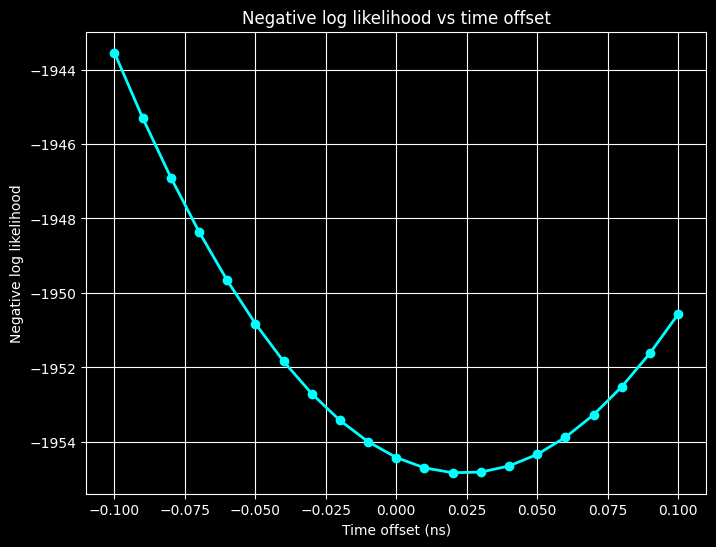

In [23]:
nlls = []
offsets = np.linspace(-0.1,0.1,21)
#offsets = [-0.03]
for offset in offsets:
    exp_ts_offset = []
    for i in range(len(exp_ts)):
        exp_ts_offset.append(exp_ts[i] + offset)
    nll = pmt.get_neg_log_likelihood_npe_t(exp_pes,np.array(obs_pes), np.array(exp_ts_offset), np.array(obs_ts))
    nlls.append(nll)

plt.figure(figsize=(8,6))
plt.plot(offsets, nlls, marker='o', color='cyan', lw=2)
plt.xlabel('Time offset (ns)')
plt.ylabel('Negative log likelihood')
plt.title('Negative log likelihood vs time offset')
plt.grid()
plt.show()

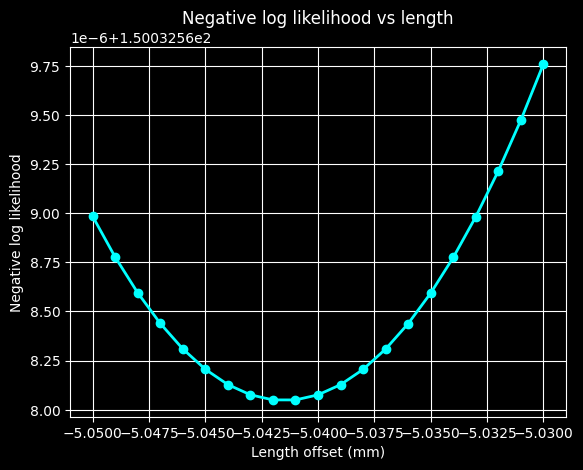

In [20]:
# look at likelihood function for small changes to length parameter
emitter_copy = emitter.copy()
nlls = []
offsets = np.linspace(-5.05,-5.03,21)
for offset in offsets:
    emitter_copy.length = 400 + offset
    exp_pes, exp_ts = emitter_copy.get_expected_pes_ts(wcte, ss, p_locations, direction_zs)
    nll = pmt.get_neg_log_likelihood_npe_t(exp_pes,np.array(obs_pes), exp_ts, np.array(obs_ts))
    nlls.append(nll)

plt.plot(offsets, nlls, marker='o', color='cyan', lw=2)
plt.xlabel('Length offset (mm)')
plt.ylabel('Negative log likelihood')
plt.title('Negative log likelihood vs length')
plt.grid()
plt.show()


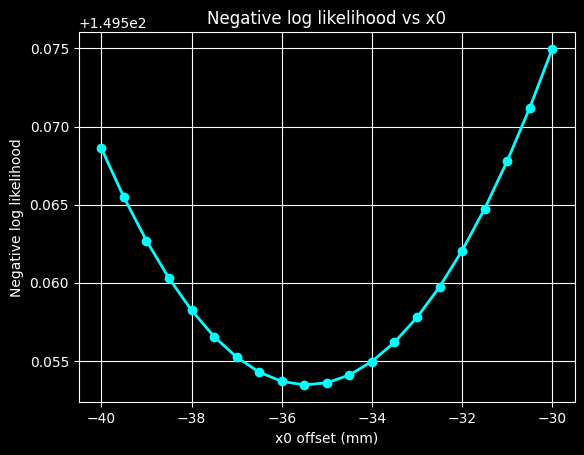

In [26]:
# look at likelihood function for small changes to x0 parameter
emitter_copy = emitter.copy()
nlls = []
offsets = np.linspace(-40,-30,21)
start_coord = emitter_copy.start_coord
for offset in offsets:
    emitter_copy.start_coord = (start_coord[0]+offset,start_coord[1],start_coord[2])
    exp_pes, exp_ts = emitter_copy.get_expected_pes_ts(wcte, ss, p_locations, direction_zs)
    nll = pmt.get_neg_log_likelihood_npe_t(exp_pes,np.array(obs_pes), exp_ts, np.array(obs_ts))
    nlls.append(nll)

plt.plot(offsets, nlls, marker='o', color='cyan', lw=2)
plt.xlabel('x0 offset (mm)')
plt.ylabel('Negative log likelihood')
plt.title('Negative log likelihood vs x0')
plt.grid()
plt.show()


In [6]:
# Change of variable equations (thanks to ChatGPT5). This is done to eliminate the strong correlation between x0 and cx and between y0 and cy.

# A line starts at Cartesian coordinates (x_0,y_0,z_0) within a cylinder of radius r and axis being the y-axis.
# The direction of the line is given by the unit vector (c_x, c_y, c_z) with c_z^2 = (1-c_x^2 -c_y^2).
# The line intersects the cylinder at the point in cylindrical coordinates (r=r, h=y_w, phi=phi_w) and that point is a distance d_w from the start of the line.
# The cylindrical coordinate phi=0 coincides with the z-axis
# At the intersection point, w_y is the cosine of the angle between the line direction and the y-axis, and w_phi is the cosine of the angle in
# the x-y plane between the line direction and the tangent to the cylinder that points in the +phi direction.


def _safe_sqrt(x):
    return np.sqrt(np.maximum(0.0, x))

# ============================================================
#  Cylinder axis = y,  phi_w = atan2(x_w, z_w)  (φ=0 on +z)
#  x_w = r*sinφ,  z_w = r*cosφ
#  n = (sinφ, 0, cosφ),  t_phi = (cosφ, 0, -sinφ)
# ============================================================

def forward_transform_and_jacobian(x_0, y_0, z_0, c_x, c_y, r, sign_cz=+1):
    """
    Forward: (x_0, y_0, z_0, c_x, c_y) -> (y_w, phi_w, d_w, w_y, w_phi), J_f (5x5)
    Cylinder axis is y; wall: x^2 + z^2 = r^2.  phi_w = atan2(x_w, z_w).
    """
    # Direction and checks
    beta_xy = c_x**2 + c_y**2
    c_z = sign_cz * _safe_sqrt(1.0 - beta_xy)
    beta = c_x**2 + c_z**2          # = 1 - c_y**2 = ||c_perp||^2
    if beta <= 0:
        raise ValueError("Degenerate direction: c_x=c_z=0 (parallel to axis).")

    # Solve (x0 + t cx)^2 + (z0 + t cz)^2 = r^2 for first t>0
    alpha = x_0*c_x + z_0*c_z
    rho0_sq = x_0**2 + z_0**2
    disc = alpha**2 + beta*(r**2 - rho0_sq)
    if disc < 0:
        raise ValueError("No intersection with cylinder (discriminant < 0).")
    d_w = (-alpha + np.sqrt(disc)) / beta

    # Hit point and cylindrical coords
    x_w = x_0 + d_w*c_x
    z_w = z_0 + d_w*c_z
    phi_w = np.arctan2(x_w, z_w)    # φ=0 on +z
    y_w = y_0 + d_w*c_y

    # Cosines
    w_y = c_y
    S, C = np.sin(phi_w), np.cos(phi_w)
    sqrt_beta = np.sqrt(beta)
    # with t_phi=(C,0,-S):  w_phi = (c_perp·t_phi)/||c_perp|| = (c_x C - c_z S)/sqrt_beta
    w_phi = (c_x*C - c_z*S) / sqrt_beta

    # Jacobian building blocks
    a = c_x*S + c_z*C            # c_perp · n (>=0 for outward hit)

    # ∂d_w/∂(x0,z0,cx,cz) at fixed (cx,cz)
    dd_dx0_ind = -S / a
    dd_dz0_ind = -C / a
    dd_dcx_ind = -d_w * S / a
    dd_dcz_ind = -d_w * C / a

    # c_z depends on (c_x, c_y):  ∂c_z/∂c_x = -c_x/c_z,  ∂c_z/∂c_y = -c_y/c_z
    dcz_dcx = -c_x / (c_z if c_z != 0 else 1e-300)
    dcz_dcy = -c_y / (c_z if c_z != 0 else 1e-300)

    # Chain to (c_x, c_y)
    dd_dx0 = dd_dx0_ind
    dd_dz0 = dd_dz0_ind
    dd_dcx = dd_dcx_ind + dd_dcz_ind * dcz_dcx
    dd_dcy = dd_dcz_ind * dcz_dcy

    # φ partials:  dφ = (-x_w dz_w + z_w dx_w)/r^2  ⇒  at wall: dφ = (C dx - S dz)/r
    dphi_dx0_ind =  C/(r*a)
    dphi_dz0_ind = -S/(r*a)
    dphi_dcx_ind =  d_w*C/(r*a)
    dphi_dcz_ind = -d_w*S/(r*a)

    dphi_dx0 = dphi_dx0_ind
    dphi_dz0 = dphi_dz0_ind
    dphi_dcx = dphi_dcx_ind + dphi_dcz_ind * dcz_dcx
    dphi_dcy = dphi_dcz_ind * dcz_dcy   # dφ/dc_y via c_z only
    # dφ/dy0 = 0

    # Assemble forward Jacobian J_f
    J = np.zeros((5,5), dtype=float)

    # (1) y_w = y_0 + d_w c_y
    J[0,0] = c_y * dd_dx0
    J[0,1] = 1.0
    J[0,2] = c_y * dd_dz0
    J[0,3] = c_y * dd_dcx
    J[0,4] = d_w + c_y * dd_dcy

    # (2) φ_w
    J[1,0] = dphi_dx0
    J[1,1] = 0.0
    J[1,2] = dphi_dz0
    J[1,3] = dphi_dcx
    J[1,4] = dphi_dcy

    # (3) d_w
    J[2,0] = dd_dx0
    J[2,1] = 0.0
    J[2,2] = dd_dz0
    J[2,3] = dd_dcx
    J[2,4] = dd_dcy

    # (4) w_y = c_y
    J[3,0] = 0.0
    J[3,1] = 0.0
    J[3,2] = 0.0
    J[3,3] = 0.0
    J[3,4] = 1.0

    # (5) w_phi = (c_x C - c_z S)/sqrt_beta
    inv_sqrtb = 1.0/(sqrt_beta if sqrt_beta != 0 else 1e-300)
    inv_beta  = 1.0/(beta if beta != 0 else 1e-300)

    # φ-coupling factor:  ∂w_phi/∂φ at fixed (cx,cz) equals (-a)/sqrt_beta
    fac = (-a) * inv_sqrtb

    # wrt (x0,y0,z0): only via φ
    J[4,0] = fac * dphi_dx0
    J[4,1] = 0.0
    J[4,2] = fac * dphi_dz0

    # wrt (c_x, c_y) including c_z and φ dependences
    # general: dw = (C dcx - S dcz)/sqrtβ + fac dφ - w_phi/β (c_x dcx + c_z dcz)
    coeff_dcz = (-S)*inv_sqrtb - w_phi * c_z * inv_beta
    coeff_dcx = ( C)*inv_sqrtb - w_phi * c_x * inv_beta

    J[4,3] = coeff_dcx + coeff_dcz * dcz_dcx + fac * dphi_dcx      # ∂/∂c_x
    J[4,4] =            coeff_dcz * dcz_dcy + fac * dphi_dcy        # ∂/∂c_y

    return (y_w, phi_w, d_w, w_y, w_phi), J


def inverse_transform_and_jacobian(y_w, phi_w, d_w, w_y, w_phi, r, sign_cz=+1):
    """
    Inverse: (y_w, phi_w, d_w, w_y, w_phi) -> (x_0, y_0, z_0, c_x, c_y), J_g (5x5)
    Using t_phi = (cosφ, 0, -sinφ).
    """
    S, C = np.sin(phi_w), np.cos(phi_w)
    s  = _safe_sqrt(1.0 - w_phi**2)   # = sin(angle to t_phi) in xz-plane
    sb = _safe_sqrt(1.0 - w_y**2)     # = ||c_perp||

    # Direction (c_perp = sb*(w_phi t_phi + s n))
    c_y = w_y
    c_x = sb * ( w_phi*C + s*S)
    c_z = sb * (-w_phi*S + s*C)

    # Optional: enforce chosen c_z branch sign
    if sign_cz < 0 and c_z > 0: c_z = -c_z
    if sign_cz > 0 and c_z < 0: c_z = -c_z

    # Wall point and start point
    x_w = r*S
    z_w = r*C
    x_0 = x_w - d_w*c_x
    y_0 = y_w - d_w*c_y
    z_0 = z_w - d_w*c_z

    # Inverse Jacobian J_g
    J = np.zeros((5,5), dtype=float)

    # helpers
    dsb_dwy = -(w_y / (sb if sb != 0 else 1e-300))
    ds_dwp  = -(w_phi / (s  if s  != 0 else 1e-300))

    # Direction partials
    # c_x = sb*( w_phi*C + s*S)
    dcx_dphi = sb * ( w_phi*(-S) + s*C)
    dcx_dwy  = dsb_dwy * ( w_phi*C + s*S)
    dcx_dwp  = sb * ( C + ds_dwp*S)

    # c_z = sb*(-w_phi*S + s*C)
    dcz_dphi = sb * ( -w_phi*C - s*S)
    dcz_dwy  = dsb_dwy * (-w_phi*S + s*C)
    dcz_dwp  = sb * ( -S + ds_dwp*C)

    # Rows for start point: x_0 = r*S - d_w*c_x;  z_0 = r*C - d_w*c_z;  y_0 = y_w - d_w*c_y
    J[0,0] = 0.0
    J[0,1] =  r*C - d_w*dcx_dphi
    J[0,2] = -c_x
    J[0,3] = -d_w*dcx_dwy
    J[0,4] = -d_w*dcx_dwp

    J[1,0] = 1.0
    J[1,1] = 0.0
    J[1,2] = -c_y
    J[1,3] = -d_w
    J[1,4] = 0.0

    J[2,0] = 0.0
    J[2,1] = -r*S - d_w*dcz_dphi       # because d(r*C)/dφ = -r*S
    J[2,2] = -c_z
    J[2,3] = -d_w*dcz_dwy
    J[2,4] = -d_w*dcz_dwp

    # Rows for direction (outputs 4,5)
    J[3,0] = 0.0
    J[3,1] = dcx_dphi
    J[3,2] = 0.0
    J[3,3] = dcx_dwy
    J[3,4] = dcx_dwp

    J[4,0] = 0.0
    J[4,1] = 0.0
    J[4,2] = 0.0
    J[4,3] = 1.0
    J[4,4] = 0.0

    return (x_0, y_0, z_0, c_x, c_y), J



In [7]:
# define functions for minuit to minimize with arguments being the track parameters
# make a copy of the emitter to preserve the original

emitter_copy = emitter.copy()
p_locations, direction_zs = emitter_copy.get_pmt_placements(simulated_event, wcte,'design')

obs_pes = []
obs_ts = []
for i_mpmt in range(n_mpmt):
    if simulated_event.mpmt_status[i_mpmt]:
        for i_pmt in range(simulated_event.npmt_per_mpmt):
            if simulated_event.pmt_status[i_mpmt][i_pmt]:
                obs_pe = 0
                obs_t = None
                if len(simulated_event.expected_hit_pe[i_mpmt][i_pmt]) > 0:
                    obs_pe = simulated_event.true_hit_pe[i_mpmt][i_pmt][0]
                    if obs_pe > 0 and len(simulated_event.hit_times[i_mpmt][i_pmt]) > 0:
                        obs_t = simulated_event.hit_times[i_mpmt][i_pmt][0]
                obs_pes.append(obs_pe)
                obs_ts.append(obs_t)

obs_pes = np.array(obs_pes)
obs_ts = np.array(obs_ts)

counters = [0,0]

def get_neg_log_likelihood_npe(x0, y0, z0, cx, cy, length):
    cz = np.sqrt(1.-cx**2-cy**2)
    direction = (cx, cy, cz)
    start_coord = (x0, y0, z0)
    emitter_copy.start_coord = start_coord
    emitter_copy.direction = direction
    emitter_copy.length = length

    ss = emitter_copy.get_emission_points(p_locations)
    exp_pes, exp_ts = emitter_copy.get_expected_pes_ts(wcte, ss, p_locations, direction_zs)
    neg_ll = pmt.get_neg_log_likelihood_npe(exp_pes,obs_pes)

    counters[0] += 1
    print(f'{counters[0]}: x0={x0:.1f}, y0={y0:.1f}, z0={z0:.1f}, cx={cx:.4f}, cy={cy:.4f}, length={length:.1f} => neg log likelihood = {neg_ll:.4f}')

    return neg_ll

# alternative version using transformed parameters
def get_neg_log_likelihood_npe_alt(y_w, phi_w, d_w, w_y, w_phi, length):
    r = 1464. # design radius of WCTE
    (x0, y0, z0, cx, cy), J = inverse_transform_and_jacobian(y_w, phi_w, d_w, w_y, w_phi, r, sign_cz=+1)
    return get_neg_log_likelihood_npe(x0, y0, z0, cx, cy, length)

def get_neg_log_likelihood_npe_t(x0, y0, z0, cx, cy, length, t0):
    cz = np.sqrt(1.-cx**2-cy**2)
    direction = (cx, cy, cz)
    start_coord = (x0, y0, z0)
    emitter_copy.start_coord = start_coord
    emitter_copy.starting_time = t0
    emitter_copy.direction = direction
    emitter_copy.length = length

    ss = emitter_copy.get_emission_points(p_locations)
    exp_pes, exp_ts = emitter_copy.get_expected_pes_ts(wcte, ss, p_locations, direction_zs)
    neg_ll = pmt.get_neg_log_likelihood_npe_t(exp_pes,obs_pes,exp_ts,obs_ts)

    counters[1] += 1
    print(f'{counters[1]}: x0={x0:.1f}, y0={y0:.1f}, z0={z0:.1f}, cx={cx:.4f}, cy={cy:.4f}, length={length:.1f}, t0={t0:.1f} => neg log likelihood = {neg_ll:.4f}')

    return neg_ll

# alternative version using transformed parameters
def get_neg_log_likelihood_npe_t_alt(y_w, phi_w, d_w, w_y, w_phi, length, t0):
    r = 1464. # design radius of WCTE
    (x0, y0, z0, cx, cy), J = inverse_transform_and_jacobian(y_w, phi_w, d_w, w_y, w_phi, r, sign_cz=+1)
    return get_neg_log_likelihood_npe_t(x0, y0, z0, cx, cy, length, t0)

# second alternative version using transformed parameters: replacing w_phi with dw_phi = w_phi - 3 phi_w
def get_neg_log_likelihood_npe_t_alt2(y_w, phi_w, d_w, w_y, dw_phi, length, t0):
    r = 1464. # design radius of WCTE
    w_phi = dw_phi + 3*phi_w
    (x0, y0, z0, cx, cy), J = inverse_transform_and_jacobian(y_w, phi_w, d_w, w_y, w_phi, r, sign_cz=+1)
    print(f'y_w={y_w:.1f}, phi_w={phi_w:.3f}, d_w={d_w:.1f}, w_y={w_y:.3f}, dw_phi={dw_phi:.3f}')
    return get_neg_log_likelihood_npe_t(x0, y0, z0, cx, cy, length, t0)


In [72]:
initial_params = {
    'x0': 0., 'y0': 0., 'z0': -400.,
    'cx': 0.0, 'cy': 0.0, 'length': 400.}

param_errors = {
    'x0': 5., 'y0': 5., 'z0': 5.,
    'cx': 0.01, 'cy': 0.01, 'length': 50.}
limits = {
    'x0': (-2000, 2000), 'y0': (-2000, 4000), 'z0': (-3000, 3000),
    'cx': (-0.7, 0.7), 'cy': (-0.7, 0.7), 'length': (10., 4000.)}
fixed = {
    'x0': False, 'y0': False, 'z0': False,
    'cx': False, 'cy': False, 'length': False}

my_npe_fitter = Fitter(get_neg_log_likelihood_npe, initial_params, param_errors=param_errors, limits=limits, fixed=fixed)

In [19]:
initial_params = {
    'x0': 10., 'y0': 0., 'z0': -400.,
    'cx': 0.0, 'cy': 0.0, 'length': 400., 't0': 10.}

param_errors = {
    'x0': 5., 'y0': 5., 'z0': 5.,
    'cx': 0.01, 'cy': 0.01, 'length': 50., 't0':0.1}
limits = {
    'x0': (-2000, 2000), 'y0': (-2000, 4000), 'z0': (-3000, 3000),
    'cx': (-0.7, 0.7), 'cy': (-0.7, 0.7), 'length': (10., 4000.), 't0':(-100.,100.)}
fixed = {
    'x0': False, 'y0': False, 'z0': False,
    'cx': False, 'cy': False, 'length': False, 't0': False}

my_npe_t_fitter = Fitter(get_neg_log_likelihood_npe_t, initial_params, param_errors=param_errors, limits=limits, fixed=fixed)

In [12]:
my_npe_fitter.minimize()

1: x0=0.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 75.3412
2: x0=0.1, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 75.3560
3: x0=-0.1, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 75.3265
4: x0=0.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 75.3490
5: x0=-0.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 75.3334
6: x0=0.0, y0=0.1, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 75.3377
7: x0=0.0, y0=-0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 75.3448
8: x0=0.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 75.3392
9: x0=0.0, y0=-0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 75.3433
10: x0=0.0, y0=0.0, z0=-399.9, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 75.3432
11: x0=0.0, y0=0.0, z0=-4

(<ValueView x0=67.16914497124662 y0=-58.27216454377799 z0=-395.26473079783955 cx=-0.031000212298472496 cy=0.025717124803081415 length=401.0418602569261>,
 <ErrorView x0=73.59865462696166 y0=37.61529713066773 z0=9.421922752824685 cx=0.03035297334015702 cy=0.0150105489164985 length=9.992201966687588>)

In [27]:
my_npe_fitter.minimizer.migrad()

1: x0=0.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 107.9858
2: x0=0.1, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 107.9563
3: x0=-0.1, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 108.0155
4: x0=0.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 107.9695
5: x0=-0.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 108.0022
6: x0=0.0, y0=0.1, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 107.9619
7: x0=0.0, y0=-0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 108.0098
8: x0=0.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 107.9708
9: x0=0.0, y0=-0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 108.0009
10: x0=0.0, y0=0.0, z0=-399.9, cx=0.0000, cy=0.0000, length=400.0 => neg log likelihood = 107.9749
11: x0=0.0, y0=

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 83.02                      │             Nfcn = 2212              │
│ EDM = 0.142 (Goal: 0.0001)       │            time = 5.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0     │   139.0   │    0.4    │            │            │  -2000  │  2000   │       │
│ 1 │ y0     │    -5     │     6     │            │            │  -2000  │  4000   │       │
│ 2 │ z0     │  -384.4   │    0.4    │            │            │  -3000  │  3000   │       │
│ 3 │ cx     │ -44.14e-3 │  0.10e-3  │            │            │  -0.7   │   0.7   │       │
│ 4 │ cy     │  0.0105   │  0.0029   │            │            │  -0.7   │   0.7   │       │
│ 5 │ length │   389.6   │    0.9    │            │            │   10    │  4000   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────┐
│        │         x0         y0         z0         cx         cy     length │
├────────┼───────────────────────────────────────────────────────────────────┤
│     x0 │      0.164       0.51       0.02  -35.31e-6    -373e-6       0.06 │
│     y0 │       0.51       30.9       0.39  11.509e-6 -15.417e-3        2.1 │
│     z0 │       0.02       0.39      0.198  11.513e-6    -359e-6      -0.15 │
│     cx │  -35.31e-6  11.509e-6  11.513e-6      1e-08  -0.007e-6  -2.032e-6 │
│     cy │    -373e-6 -15.417e-3    -359e-6  -0.007e-6   8.28e-06  -1.299e-3 │
│ length │       0.06        2.1      -0.15  -2.032e-6  -1.299e-3      0.794 │
└────────┴───────────────────────────────────────────────────────────────────┘

In [15]:
my_npe_fitter.minimizer.minos()

1085: x0=-66.9, y0=0.7, z0=-394.9, cx=0.0355, cy=0.0104, length=396.3 => neg log likelihood = -2041.7723
1086: x0=-66.9, y0=0.7, z0=-394.9, cx=0.0355, cy=0.0104, length=396.3 => neg log likelihood = -2041.7711
1087: x0=-66.9, y0=0.7, z0=-394.9, cx=0.0355, cy=0.0104, length=396.3 => neg log likelihood = -2041.7736
1088: x0=-66.9, y0=0.8, z0=-394.9, cx=0.0355, cy=0.0104, length=396.3 => neg log likelihood = -2041.7640
1089: x0=-66.9, y0=0.6, z0=-394.9, cx=0.0355, cy=0.0104, length=396.3 => neg log likelihood = -2041.7733
1090: x0=-66.9, y0=0.7, z0=-394.9, cx=0.0355, cy=0.0104, length=396.3 => neg log likelihood = -2041.7735
1091: x0=-66.9, y0=0.7, z0=-394.9, cx=0.0355, cy=0.0104, length=396.3 => neg log likelihood = -2041.7711
1092: x0=-66.9, y0=0.7, z0=-394.8, cx=0.0355, cy=0.0104, length=396.3 => neg log likelihood = -2041.7747
1093: x0=-66.9, y0=0.7, z0=-395.0, cx=0.0355, cy=0.0104, length=396.3 => neg log likelihood = -2041.7611
1094: x0=-66.9, y0=0.7, z0=-394.9, cx=0.0355, cy=0.0104

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2042                      │             Nfcn = 2891              │
│ EDM = 0.000695 (Goal: 0.0001)    │            time = 1.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0     │  -67.25   │   0.33    │   -0.33    │    0.33    │  -2000  │  2000   │       │
│ 1 │ y0     │    0.6    │    0.4    │    -0.4    │    0.4     │  -2000  │  4000   │       │
│ 2 │ z0     │  -394.91  │   0.27    │   -0.27    │    0.27    │  -3000  │  3000   │       │
│ 3 │ cx     │ 35.60e-3  │  0.15e-3  │  -0.15e-3  │  0.15e-3   │  -0.7   │   0.7   │       │
│ 4 │ cy     │ 10.42e-3  │  0.16e-3  │  -0.16e-3  │  0.16e-3   │  -0.7   │   0.7   │       │
│ 5 │ length │   396.6   │    2.2    │    -2.2    │    2.2     │   10    │  4000   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          x0           │          y0           │          z0           │          cx           │          cy           │        length         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.33   │   0.33    │   -0.4    │    0.4    │   -0.27   │   0.27    │ -0.15e-3  │  0.15e-3  │ -0.16e-3  │  0.16e-3  │   -2.2    │    2.2    │
│  Valid   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────────┬───────────────────────────────────────────────────────────────────┐
│        │         x0         y0         z0         cx         cy     length │
├────────┼───────────────────────────────────────────────────────────────────┤
│     x0 │      0.107       0.01       0.00 -34.662e-6  -1.279e-6      -0.09 │
│     y0 │       0.01      0.181      -0.00  -4.025e-6 -72.386e-6      -0.04 │
│     z0 │       0.00      -0.00     0.0711 -15.154e-6  -9.026e-6      -0.17 │
│     cx │ -34.662e-6  -4.025e-6 -15.154e-6   2.21e-08   0.001e-6  94.064e-6 │
│     cy │  -1.279e-6 -72.386e-6  -9.026e-6   0.001e-6   2.55e-08   8.613e-6 │
│ length │      -0.09      -0.04      -0.17  94.064e-6   8.613e-6       4.78 │
└────────┴────────────────────────

In [17]:
my_npe_t_fitter.minimize()

1: x0=10.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 182.3734
2: x0=10.1, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 182.3839
3: x0=9.9, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 182.3631
4: x0=10.0, y0=0.1, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 182.3857
5: x0=10.0, y0=-0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 182.3612
6: x0=10.0, y0=0.0, z0=-399.9, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 182.3842
7: x0=10.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 182.3627
8: x0=10.0, y0=0.0, z0=-400.0, cx=0.0001, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 182.4257
9: x0=10.0, y0=0.0, z0=-400.0, cx=-0.0001, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 180.7198
10: x0=10.0, y0=0.0, z0=-40

RuntimeError: Minimization did not converge

In [20]:
my_npe_t_fitter.minimizer.tol = 100.
my_npe_t_fitter.minimizer.migrad(ncall=50000)

6012: x0=10.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 156.6373
6013: x0=10.1, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 156.6248
6014: x0=9.9, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 156.6499
6015: x0=10.0, y0=0.1, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 156.6092
6016: x0=10.0, y0=-0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 156.6655
6017: x0=10.0, y0=0.0, z0=-399.9, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 156.6189
6018: x0=10.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 156.6559
6019: x0=10.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 156.6235
6020: x0=10.0, y0=0.0, z0=-400.0, cx=0.0000, cy=0.0000, length=400.0, t0=10.0 => neg log likelihood = 156.6512
6

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 136.4                      │              Nfcn = 253              │
│ EDM = 0.0517 (Goal: 0.1)         │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0     │    24     │    28     │            │            │  -2000  │  2000   │       │
│ 1 │ y0     │    -0     │    33     │            │            │  -2000  │  4000   │       │
│ 2 │ z0     │   -388    │     6     │            │            │  -3000  │  3000   │       │
│ 3 │ cx     │   0.002   │   0.011   │            │            │  -0.7   │   0.7   │       │
│ 4 │ cy     │   0.009   │   0.013   │            │            │  -0.7   │   0.7   │       │
│ 5 │ length │    385    │     9     │            │            │   10    │  4000   │       │
│ 6 │ t0     │   9.96    │   0.07    │            │            │  -100   │   100   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────┐
│        │         x0         y0         z0         cx         cy     length         t0 │
├────────┼──────────────────────────────────────────────────────────────────────────────┤
│     x0 │        763         -0          5 -308.36e-3   11.72e-3         10      0.212 │
│     y0 │         -0   1.05e+03        -25   10.26e-3 -415.34e-3        -50     -0.445 │
│     z0 │          5        -25         35    1.02e-3    4.87e-3        -27      0.127 │
│     cx │ -308.36e-3   10.26e-3    1.02e-3   0.000129         -0   -3.25e-3   -0.07e-3 │
│     cy │   11.72e-3 -415.34e-3    4.87e-3         -0   0.000171   20.70e-3    0.16e-3 │
│ length │         10        -50        -27   -3.25e-3   20.70e-3       79.8     -0.071 │
│     t0 │      0.212     -0.445      0.127   -0.07e-3    0.16e-3     -0.071    0.00443 │
└────────┴──────────────────────────────────────────────────────────────────────────────┘

In [21]:
my_npe_t_fitter.minimizer.minos()

6265: x0=51.6, y0=-1.4, z0=-388.2, cx=-0.0091, cy=0.0091, length=385.0, t0=10.0 => neg log likelihood = 136.8133
6266: x0=51.6, y0=-1.1, z0=-388.2, cx=-0.0091, cy=0.0091, length=385.0, t0=10.0 => neg log likelihood = 136.7987
6267: x0=51.6, y0=-1.8, z0=-388.2, cx=-0.0091, cy=0.0091, length=385.0, t0=10.0 => neg log likelihood = 136.8326
6268: x0=51.6, y0=-1.4, z0=-388.2, cx=-0.0091, cy=0.0091, length=385.0, t0=10.0 => neg log likelihood = 136.8112
6269: x0=51.6, y0=-1.5, z0=-388.2, cx=-0.0091, cy=0.0091, length=385.0, t0=10.0 => neg log likelihood = 136.8154
6270: x0=51.6, y0=-1.4, z0=-388.2, cx=-0.0091, cy=0.0091, length=385.0, t0=10.0 => neg log likelihood = 136.8102
6271: x0=51.6, y0=-1.4, z0=-388.3, cx=-0.0091, cy=0.0091, length=385.0, t0=10.0 => neg log likelihood = 136.8166
6272: x0=51.6, y0=-1.4, z0=-388.2, cx=-0.0091, cy=0.0091, length=385.0, t0=10.0 => neg log likelihood = 136.8115
6273: x0=51.6, y0=-1.4, z0=-388.3, cx=-0.0091, cy=0.0091, length=385.0, t0=10.0 => neg log likel

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 136.4                      │             Nfcn = 3798              │
│ EDM = 0.0517 (Goal: 0.1)         │            time = 8.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0     │    24     │    28     │    -27     │     32     │  -2000  │  2000   │       │
│ 1 │ y0     │    -0     │    32     │    -29     │     32     │  -2000  │  4000   │       │
│ 2 │ z0     │   -388    │     6     │     -6     │     5      │  -3000  │  3000   │       │
│ 3 │ cx     │   0.002   │   0.011   │   -0.011   │   0.011    │  -0.7   │   0.7   │       │
│ 4 │ cy     │   0.009   │   0.013   │   -0.013   │   0.012    │  -0.7   │   0.7   │       │
│ 5 │ length │    385    │     9     │     -7     │     10     │   10    │  4000   │       │
│ 6 │ t0     │   9.96    │   0.07    │   -0.06    │    0.07    │  -100   │   100   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          x0           │          y0           │          z0           │          cx           │          cy           │        length         │          t0           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -27    │    32     │    -29    │    32     │    -6     │     5     │  -0.011   │   0.011   │  -0.013   │   0.012   │    -7     │    10     │   -0.06   │   0.07    │
│  Valid   │   True    │   True    │   True    │   False   │   True    │   True    │   False   │   True    │   False   │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────┐
│        │         x0         y0         z0         cx         cy     length         t0 │
├────────┼──────────────────────────────────────────────────────────────────────────────┤
│     x0 │        763         -0          5 -308.36e-3   11.72e-3         10      0.212 │
│     y0 │         -0   1.05e+03        -25   10.26e-3 -415.34e-3        -50

In [75]:
# alternative using transformed parameters

initial_params = {
    'y_w': 20, 'phi_w': 0.01, 'd_w': 1464+400.,
    'w_y': 0.01, 'w_phi': 0.01, 'length': 400.}
param_errors = {
    'y_w': 10, 'phi_w': 0.01, 'd_w': 5.,
    'w_y': 0.01, 'w_phi': 0.01, 'length': 5.}
limits = {
    'y_w': (-2000, 4000), 'phi_w': (-np.pi, np.pi), 'd_w': (10., 4000.),
    'w_y': (-0.99, 0.99), 'w_phi': (-0.99, 0.99), 'length': (10., 4000.)}
fixed = {
    'y_w': False, 'phi_w': False, 'd_w': False,
    'w_y': False, 'w_phi': False, 'length': False}

my_npe_fitter_alt = Fitter(get_neg_log_likelihood_npe_alt, initial_params, param_errors=param_errors, limits=limits, fixed=fixed)


In [76]:
my_npe_fitter_alt.minimizer.migrad(ncall=50000)

1: x0=-22.6, y0=1.4, z0=-399.6, cx=0.0200, cy=0.0100, length=400.0 => neg log likelihood = 87.7458
2: x0=-22.6, y0=1.5, z0=-399.6, cx=0.0200, cy=0.0100, length=400.0 => neg log likelihood = 87.7516
3: x0=-22.6, y0=1.3, z0=-399.6, cx=0.0200, cy=0.0100, length=400.0 => neg log likelihood = 87.7401
4: x0=-22.6, y0=1.4, z0=-399.6, cx=0.0200, cy=0.0100, length=400.0 => neg log likelihood = 87.7491
5: x0=-22.6, y0=1.3, z0=-399.6, cx=0.0200, cy=0.0100, length=400.0 => neg log likelihood = 87.7425
6: x0=-22.7, y0=1.4, z0=-399.6, cx=0.0201, cy=0.0100, length=400.0 => neg log likelihood = 87.7385
7: x0=-22.6, y0=1.4, z0=-399.6, cx=0.0199, cy=0.0100, length=400.0 => neg log likelihood = 87.7539
8: x0=-22.6, y0=1.4, z0=-399.6, cx=0.0200, cy=0.0100, length=400.0 => neg log likelihood = 87.7440
9: x0=-22.6, y0=1.4, z0=-399.6, cx=0.0200, cy=0.0100, length=400.0 => neg log likelihood = 87.7476
10: x0=-22.6, y0=1.4, z0=-399.7, cx=0.0200, cy=0.0100, length=400.0 => neg log likelihood = 87.7519
11: x0=-2

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 82.88                      │              Nfcn = 421              │
│ EDM = 8.52e-05 (Goal: 0.0001)    │            time = 1.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ y_w    │   11.1    │    1.3    │            │            │  -2000  │  4000   │       │
│ 1 │ phi_w  │   0.049   │   0.006   │            │            │-3.14159 │ 3.14159 │       │
│ 2 │ d_w    │  1.846e3  │  0.004e3  │            │            │   10    │  4000   │       │
│ 3 │ w_y    │   0.01    │   0.06    │            │            │  -0.99  │  0.99   │       │
│ 4 │ w_phi  │  -0.116   │   0.010   │            │            │  -0.99  │  0.99   │       │
│ 5 │ length │    393    │     7     │            │            │   10    │  4000   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────┐
│        │        y_w      phi_w        d_w        w_y      w_phi     length │
├────────┼───────────────────────────────────────────────────────────────────┤
│    y_w │       1.75  -6.253e-3        5.5     -0.078   -3.73e-3       -4.1 │
│  phi_w │  -6.253e-3   3.14e-05 -19.961e-3   0.284e-3  -0.005e-3  17.865e-3 │
│    d_w │        5.5 -19.961e-3       17.7     -0.255  -12.48e-3        -13 │
│    w_y │     -0.078   0.284e-3     -0.255    0.00372    0.19e-3      0.190 │
│  w_phi │   -3.73e-3  -0.005e-3  -12.48e-3    0.19e-3   0.000103    4.09e-3 │
│ length │       -4.1  17.865e-3        -13      0.190    4.09e-3       52.7 │
└────────┴───────────────────────────────────────────────────────────────────┘

In [16]:
# alternative using transformed parameters

initial_params = {
    'y_w': 20., 'phi_w': 0., 'd_w': 1464+400.,
    'w_y': 0.01, 'w_phi': 0.01, 'length': 400., 't0': 10.}
param_errors = {
    'y_w': 10., 'phi_w': 0.01, 'd_w': 5.,
    'w_y': 0.01, 'w_phi': 0.01, 'length': 5., 't0':0.1}
limits = {
    'y_w': (-2000, 4000), 'phi_w': (-np.pi, np.pi), 'd_w': (10., 4000.),
    'w_y': (-0.99, 0.99), 'w_phi': (-0.99, 0.99), 'length': (10., 4000.), 't0':(-100.,100.)}
fixed = {
    'y_w': False, 'phi_w': False, 'd_w': False,
    'w_y': False, 'w_phi': False, 'length': False, 't0': False}

my_npe_fitter_t_alt = Fitter(get_neg_log_likelihood_npe_t_alt, initial_params, param_errors=param_errors, limits=limits, fixed=fixed)


In [17]:
# set a suitable scale for evaluating likelihood function. Given PMT segmentation, tiny changes to track parameters is invalid.
my_npe_fitter_t_alt.minimizer.tol = 100.
my_npe_fitter_t_alt.minimizer.migrad(ncall=50000)

2732: x0=-18.6, y0=1.4, z0=-399.8, cx=0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 153.2347
2733: x0=-18.6, y0=1.5, z0=-399.8, cx=0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 153.2285
2734: x0=-18.6, y0=1.3, z0=-399.8, cx=0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 153.2413
2735: x0=-18.6, y0=1.4, z0=-399.8, cx=0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 153.2316
2736: x0=-18.6, y0=1.3, z0=-399.8, cx=0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 153.2379
2737: x0=-18.7, y0=1.4, z0=-399.8, cx=0.0101, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 153.1151
2738: x0=-18.6, y0=1.4, z0=-399.8, cx=0.0099, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 153.3567
2739: x0=-18.6, y0=1.4, z0=-399.8, cx=0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 153.2140
2740: x0=-18.6, y0=1.4, z0=-399.8, cx=0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 1

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 136.5                      │              Nfcn = 276              │
│ EDM = 0.065 (Goal: 0.1)          │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ y_w    │    15     │    10     │            │            │  -2000  │  4000   │       │
│ 1 │ phi_w  │   0.019   │   0.006   │            │            │-3.14159 │ 3.14159 │       │
│ 2 │ d_w    │  1.851e3  │  0.005e3  │            │            │   10    │  4000   │       │
│ 3 │ w_y    │   0.010   │   0.013   │            │            │  -0.99  │  0.99   │       │
│ 4 │ w_phi  │  -0.016   │   0.017   │            │            │  -0.99  │  0.99   │       │
│ 5 │ length │    384    │     9     │            │            │   10    │  4000   │       │
│ 6 │ t0     │   9.97    │   0.07    │            │            │  -100   │   100   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────┐
│        │        y_w      phi_w        d_w        w_y      w_phi     length         t0 │
├────────┼──────────────────────────────────────────────────────────────────────────────┤
│    y_w │        101  -4.753e-3         15 -101.95e-3   12.36e-3        -10     -0.156 │
│  phi_w │  -4.753e-3   3.05e-05  -4.901e-3   0.005e-3  -0.086e-3   2.321e-3   0.054e-3 │
│    d_w │         15  -4.901e-3       28.1   -1.76e-3    5.73e-3         21     -0.102 │
│    w_y │ -101.95e-3   0.005e-3   -1.76e-3   0.000175   -0.01e-3   22.64e-3    0.16e-3 │
│  w_phi │   12.36e-3  -0.086e-3    5.73e-3   -0.01e-3   0.000285   -6.91e-3   -0.14e-3 │
│ length │        -10   2.321e-3         21   22.64e-3   -6.91e-3       74.8     -0.048 │
│     t0 │     -0.156   0.054e-3     -0.102    0.16e-3   -0.14e-3     -0.048    0.00435 │
└────────┴──────────────────────────────────────────────────────────────────────────────┘

In [18]:
my_npe_fitter_t_alt.minimizer.minos()

3008: x0=20.0, y0=25.8, z0=-388.4, cx=0.0036, cy=-0.0002, length=382.4, t0=10.0 => neg log likelihood = 137.1721
3009: x0=20.0, y0=25.8, z0=-388.4, cx=0.0036, cy=-0.0002, length=382.4, t0=10.0 => neg log likelihood = 137.1667
3010: x0=20.0, y0=25.8, z0=-388.4, cx=0.0035, cy=-0.0002, length=382.4, t0=10.0 => neg log likelihood = 137.1784
3011: x0=20.0, y0=25.8, z0=-388.4, cx=0.0036, cy=-0.0002, length=382.4, t0=10.0 => neg log likelihood = 137.1705
3012: x0=20.0, y0=25.8, z0=-388.4, cx=0.0036, cy=-0.0002, length=382.4, t0=10.0 => neg log likelihood = 137.1738
3013: x0=20.0, y0=25.8, z0=-388.5, cx=0.0036, cy=-0.0002, length=382.4, t0=10.0 => neg log likelihood = 137.1685
3014: x0=20.0, y0=25.8, z0=-388.4, cx=0.0036, cy=-0.0002, length=382.4, t0=10.0 => neg log likelihood = 137.1759
3015: x0=20.0, y0=25.8, z0=-388.5, cx=0.0036, cy=-0.0002, length=382.4, t0=10.0 => neg log likelihood = 137.1700
3016: x0=20.0, y0=25.8, z0=-388.4, cx=0.0036, cy=-0.0002, length=382.4, t0=10.0 => neg log likel

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 136.5                      │             Nfcn = 3280              │
│ EDM = 0.065 (Goal: 0.1)          │            time = 7.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ y_w    │    15     │    10     │     -8     │     9      │  -2000  │  4000   │       │
│ 1 │ phi_w  │   0.019   │   0.006   │   -0.005   │   0.006    │-3.14159 │ 3.14159 │       │
│ 2 │ d_w    │  1.851e3  │  0.005e3  │  -0.004e3  │  0.007e3   │   10    │  4000   │       │
│ 3 │ w_y    │   0.010   │   0.013   │   -0.012   │   0.011    │  -0.99  │  0.99   │       │
│ 4 │ w_phi  │  -0.016   │   0.017   │   -0.020   │   0.015    │  -0.99  │  0.99   │       │
│ 5 │ length │    384    │     9     │     -7     │     9      │   10    │  4000   │       │
│ 6 │ t0     │   9.97    │   0.07    │   -0.07    │    0.06    │  -100   │   100   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          y_w          │         phi_w         │          d_w          │          w_y          │         w_phi         │        length         │          t0           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -8     │     9     │  -0.005   │   0.006   │    -4     │     7     │  -0.012   │   0.011   │  -0.020   │   0.015   │    -7     │     9     │   -0.07   │   0.06    │
│  Valid   │   True    │   True    │   True    │   False   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   False   │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────┐
│        │        y_w      phi_w        d_w        w_y      w_phi     length         t0 │
├────────┼──────────────────────────────────────────────────────────────────────────────┤
│    y_w │        101  -4.753e-3         15 -101.95e-3   12.36e-3        -10     -0.156 │
│  phi_w │  -4.753e-3   3.05e-05  -4.901e-3   0.005e-3  -0.086e-3   2.321e-3

In [54]:
# second alternative using transformed parameters

initial_params = {
    'y_w': 0.1, 'phi_w': 0., 'd_w': 1464+400.,
    'w_y': 0.01, 'dw_phi': 0.01, 'length': 400., 't0': 10.}
param_errors = {
    'y_w': 0.1, 'phi_w': 0.01, 'd_w': 5.,
    'w_y': 0.01, 'dw_phi': 0.01, 'length': 5., 't0':0.1}
limits = {
    'y_w': (-200, 400), 'phi_w': (-0.2, 0.2), 'd_w': (100., 3000.),
    'w_y': (-0.2, 0.2), 'dw_phi': (-0.1, 0.1), 'length': (100., 2000.), 't0':(-20.,20.)}
fixed = {
    'y_w': False, 'phi_w': False, 'd_w': False,
    'w_y': False, 'dw_phi': False, 'length': False, 't0': False}

my_npe_fitter_t_alt2 = Fitter(get_neg_log_likelihood_npe_t_alt2, initial_params, param_errors=param_errors, limits=limits, fixed=fixed)


In [55]:
my_npe_fitter_t_alt2.minimizer.migrad(ncall=50000)

y_w=0.1, phi_w=0.000, d_w=1864.0, w_y=0.010, dw_phi=0.010
266: x0=18.6, y0=-18.5, z0=-399.8, cx=-0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 166.8824
y_w=0.1, phi_w=0.000, d_w=1864.0, w_y=0.010, dw_phi=0.010
267: x0=18.6, y0=-18.5, z0=-399.8, cx=-0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 166.8820
y_w=0.1, phi_w=0.000, d_w=1864.0, w_y=0.010, dw_phi=0.010
268: x0=18.6, y0=-18.5, z0=-399.8, cx=-0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 166.8828
y_w=0.1, phi_w=0.000, d_w=1864.0, w_y=0.010, dw_phi=0.010
269: x0=18.6, y0=-18.5, z0=-399.8, cx=-0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 166.8782
y_w=0.1, phi_w=0.000, d_w=1864.0, w_y=0.010, dw_phi=0.010
270: x0=18.6, y0=-18.5, z0=-399.8, cx=-0.0100, cy=0.0100, length=400.0, t0=10.0 => neg log likelihood = 166.8866
y_w=0.1, phi_w=0.000, d_w=1864.0, w_y=0.010, dw_phi=0.010
271: x0=19.2, y0=-18.5, z0=-399.8, cx=-0.0102, cy=0.0100, length=400.0, t0=10.0 => neg 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 136.1                      │             Nfcn = 1536              │
│ EDM = 0.000263 (Goal: 0.0001)    │            time = 3.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ y_w    │    15     │     4     │            │            │  -200   │   400   │       │
│ 1 │ phi_w  │  19.5e-3  │  0.5e-3   │            │            │  -0.2   │   0.2   │       │
│ 2 │ d_w    │ 1.8520e3  │ 0.0005e3  │            │            │   100   │  3000   │       │
│ 3 │ w_y    │   0.010   │   0.028   │            │            │  -0.2   │   0.2   │       │
│ 4 │ dw_phi │ -40.16e-3 │  0.25e-3  │            │            │  -0.1   │   0.1   │       │
│ 5 │ length │    385    │     4     │            │            │   100   │  2000   │       │
│ 6 │ t0     │   9.962   │   0.035   │            │            │   -20   │   20    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────┐
│        │        y_w      phi_w        d_w        w_y     dw_phi     length         t0 │
├────────┼──────────────────────────────────────────────────────────────────────────────┤
│    y_w │       13.7 -697.57e-6       1.58  -101.4e-3  -24.43e-6          1    -0.0247 │
│  phi_w │ -697.57e-6   2.31e-07 -232.17e-6    5.15e-6    0.10e-6 -104.43e-6    1.67e-6 │
│    d_w │       1.58 -232.17e-6      0.276   -11.9e-3  -86.80e-6       0.15    -0.0030 │
│    w_y │  -101.4e-3    5.15e-6   -11.9e-3   0.000775    0.07e-6    -8.4e-3     0.2e-3 │
│ dw_phi │  -24.43e-6    0.10e-6  -86.80e-6    0.07e-6   6.11e-08  -32.47e-6    0.30e-6 │
│ length │          1 -104.43e-6       0.15    -8.4e-3  -32.47e-6       15.7    -0.0021 │
│     t0 │    -0.0247    1.67e-6    -0.0030     0.2e-3    0.30e-6    -0.0021    0.00125 │
└────────┴──────────────────────────────────────────────────────────────────────────────┘